In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [75]:
from autorocks.data.loader.all_models_result_aggregator import create_all_models_comparison_dataset
from autorocks.dir_struct import PackageRootDir
from sysgym.envs.rocksdb import schema

param_space = schema.RocksDB10Params()

all_model = create_all_models_comparison_dataset(
    PackageRootDir / "ProcessedDataNew/rocksdb/iops/zippy_workload_15min/10_params/100_iter", save_results = False)

default = create_all_models_comparison_dataset(
    PackageRootDir / "ProcessedDataNew/rocksdb/iops/zippy_workload_15min/10_params/10_iter", save_results = False)

/Users/salabed/workspace/autorocks/autorocks/data/loader/exp_dao.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.sys_observations[col_name] = col_val


In [76]:
import autorocks.viz.viz as viz

model_comparison_data_c = viz.unify_model_name(all_model)


In [110]:
all_df = model_comparison_data_c.combine_sys_params_metric()
all_df.rename(columns = lambda x: re.sub(r"^db_bench\.\w*\.", "", x), inplace = True)
top_results = all_df[['iops'] + model_comparison_data_c.sys_params.columns.to_list()].sort_values(by='iops', ascending = True).groupby('model').last(0).T
top_results

model,BoBn,BoTorch_SingleTaskGP,PBTTuner,Random,TPE
iops,297532.0,222267.0,178468.0,184819.0,288167.0
max_background_compactions,1.0,5.0,5.0,1.0,2.0
max_background_flushes,1.0,6.0,2.0,6.0,3.0
write_buffer_size,112180092.0,727021384.0,844131530.0,312727517.0,106006917.0
max_write_buffer_number,40.0,35.0,13.0,35.0,27.0
min_write_buffer_number_to_merge,1.0,1.0,1.0,1.0,1.0
max_bytes_for_level_multiplier,7.0,20.0,8.0,13.0,16.0
block_size,96182.0,57796.0,77391.0,76062.0,49275.0
level0_file_num_compaction_trigger,1.0,1.0,3.0,3.0,1.0
level0_slowdown_writes_trigger,4.0,51.0,43.0,11.0,59.0


In [131]:
desired_order = top_results.T.sort_values(by='iops', ascending = False).drop(columns={'step', 'iteration'})
original = desired_order['iops'].copy().astype(int)

def format_number(x):
    if abs(x) >= 1e4:
        return '{:.0e}'.format(x)
    else:
        return '{:.0f}'.format(x)

df_formatted = desired_order.applymap(format_number)  # Apply to all columns
df_formatted['iops'] = original
df_formatted = df_formatted.rename(columns={'iops':'IOPS'})
df_formatted = df_formatted.T.rename(columns = {'BoTorch_SingleTaskGP': 'BoTorch'})
print(df_formatted.to_latex())

\begin{tabular}{llllll}
\toprule
model &    BoBn &     TPE & BoTorch &  Random & PBTTuner \\
\midrule
IOPS                               &  297532 &  288167 &  222267 &  184819 &   178468 \\
max\_background\_compactions         &       1 &       2 &       5 &       1 &        5 \\
max\_background\_flushes             &       1 &       3 &       6 &       6 &        2 \\
write\_buffer\_size                  &   1e+08 &   1e+08 &   7e+08 &   3e+08 &    8e+08 \\
max\_write\_buffer\_number            &      40 &      27 &      35 &      35 &       13 \\
min\_write\_buffer\_number\_to\_merge   &       1 &       1 &       1 &       1 &        1 \\
max\_bytes\_for\_level\_multiplier     &       7 &      16 &      20 &      13 &        8 \\
block\_size                         &   1e+05 &   5e+04 &   6e+04 &   8e+04 &    8e+04 \\
level0\_file\_num\_compaction\_trigger &       1 &       1 &       1 &       3 &        3 \\
level0\_slowdown\_writes\_trigger     &       4 &      59 &      51 &     

In [79]:
import re
import pandas as pd

perf_df = model_comparison_data_c.sys_observations
perf_df = pd.concat([perf_df, default.sys_observations], ignore_index = True)
perf_df.rename(columns = lambda x: re.sub(r"^db_bench\.\w*\.", "", x), inplace = True)
color_palette = viz.create_color_palette_df(
    perf_df, ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
)
perf_df[['iteration', 'step', 'iops', 'model']]

,iteration,step,iops,model
0,0,1,117505.0,BoTorch_SingleTaskGP
1,0,2,75215.0,BoTorch_SingleTaskGP
2,0,3,112905.0,BoTorch_SingleTaskGP
3,0,4,123121.0,BoTorch_SingleTaskGP
4,0,5,122138.0,BoTorch_SingleTaskGP
...,...,...,...,...
2505,0,6,175587.0,Default
2506,0,7,176168.0,Default
2507,0,8,176084.0,Default
2508,0,9,176156.0,Default


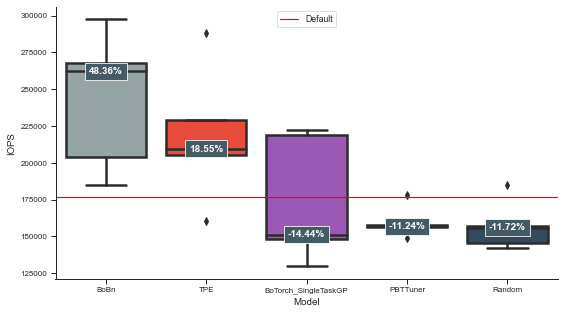

In [80]:


main_target = "iops"


iops_fig = viz.perf_boxplot(
    perf_df = perf_df,
    optimization_type = viz.OptimizationType.MAXIMIZE,
    ylabel = "IOPS",
    comparison_col = main_target,
    model_palette_map = color_palette,
    horizontal_line = "Default",
    fig_size = (9, 5),
    add_roi = True
)

iops_fig

In [81]:
iops_fig.savefig("/Users/salabed/workspace/latex_writings/thesis/phd_dissertation/Chapters/BoGraphEval/figures/rocksdb_iops.pdf", dpi= 300)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


In [82]:
model_performance = model_comparison_data_c.model_performance
model_performance.rename(columns = lambda x: re.sub(r"^db_bench\.\w*\.", "", x), inplace = True)
color_palette = viz.create_color_palette_df(
    model_performance, ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
)
model_performance

,step,inference_time,iteration,model
0,75,0.443195,0,BoTorch_SingleTaskGP
1,97,0.662626,0,BoTorch_SingleTaskGP
2,99,0.862661,0,BoTorch_SingleTaskGP
3,81,0.534748,0,BoTorch_SingleTaskGP
4,56,0.428438,0,BoTorch_SingleTaskGP
...,...,...,...,...
2495,10,0.013549,4,Random
2496,46,0.014796,4,Random
2497,98,0.013527,4,Random
2498,76,0.014062,4,Random


In [83]:
color_palette

{'BoTorch_SingleTaskGP': '#9b59b6',
 'PBTTuner': '#3498db',
 'BoBn': '#95a5a6',
 'TPE': '#e74c3c',
 'Random': '#34495e'}

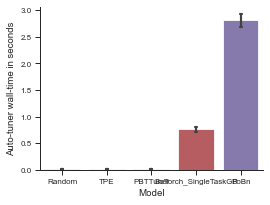

In [84]:
viz.model_perf_plot(model_perf_df=model_performance,
comparison_col='inference_time',
ylabel="Auto-tuner wall-time in seconds")



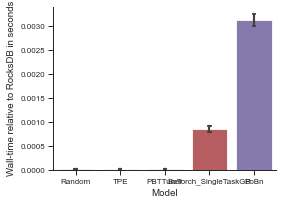

In [85]:
model_performance['relative_time'] = model_performance['inference_time'] / perf_df['exe_time']
viz.model_perf_plot(model_perf_df=model_performance,
comparison_col='relative_time',
ylabel="Wall-time relative to RocksDB in seconds")


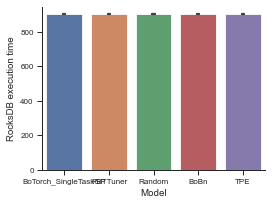

In [86]:
viz.model_perf_plot(model_perf_df=perf_df,
comparison_col='exe_time',
ylabel="RocksDB execution time")



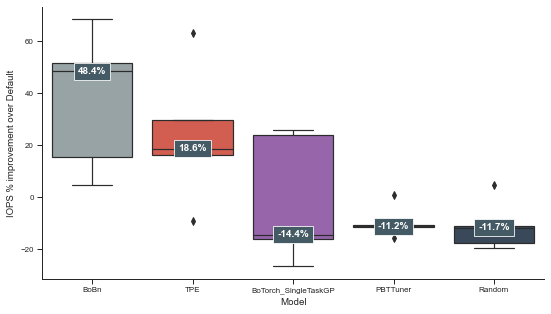

In [87]:
viz.roi_boxplot(
    df = perf_df,
    optimization_type = viz.OptimizationType.MAXIMIZE,
    ylabel = "IOPS",
    model_baseline = "Default",
    comparison_col = main_target,
    model_palette_map = color_palette,
    fig_size = (9, 5)
)

/Users/salabed/opt/anaconda3/envs/autobo/lib/python3.8/site-packages/pandas/core/apply.py:507: FutureWarning: Dropping invalid columns in DataFrameGroupBy.cummax is deprecated. In a future version, a TypeError will be raised. Before calling .cummax, select only columns which should be valid for the transforming function.
  return self._try_aggregate_string_function(obj, f, *self.args, **self.kwargs)


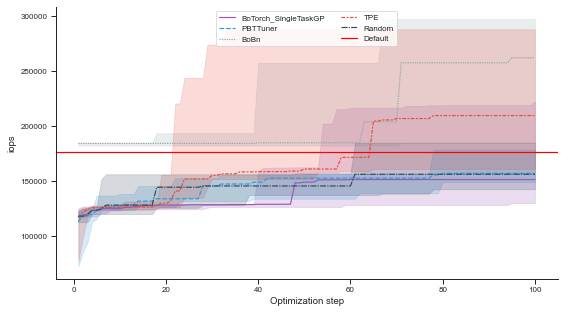

In [88]:

convergence_df = perf_df.copy()
convergence_df["rolling"] = (
    convergence_df[[main_target, "model", "iteration"]]
    .groupby(["model", "iteration"])
    [main_target]
    .agg(f"cum{str(viz.OptimizationType.MAXIMIZE)}")
)

fig = viz.convergence_lineplot(
    df=convergence_df,
    optimization_type=viz.OptimizationType.MAXIMIZE,
    ylabel=main_target,
    column_name="rolling",
    model_palette_map=color_palette,
    fig_size=(9, 5),
    horizontal_line="Default"
)
fig

In [89]:
convergence_df[main_target]

0       117505.0
1        75215.0
2       112905.0
3       123121.0
4       122138.0
          ...   
2505    175587.0
2506    176168.0
2507    176084.0
2508    176156.0
2509    175468.0
Name: iops, Length: 2510, dtype: float64